In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
house_df_org = pd.read_csv('/Users/pakeunseo/Desktop/2024-2/multicampus/py_ml_env/data/house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:

print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1460, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


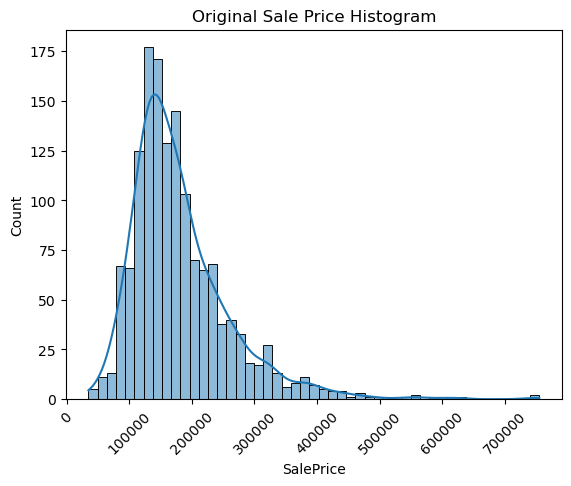

In [4]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation = 45)
sns.histplot(house_df['SalePrice'], kde= True)
plt.show()

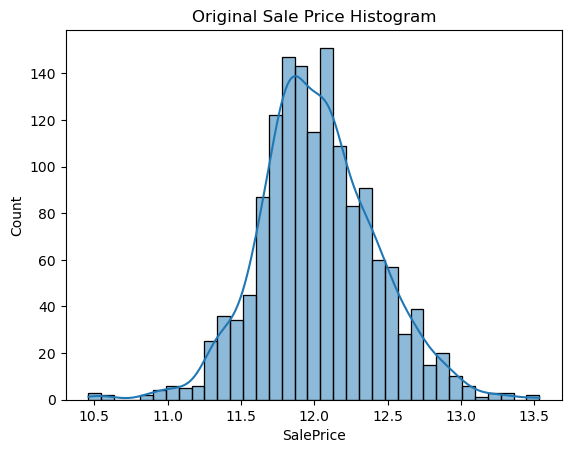

In [6]:
#로그 변환
#타겟을 정규 분포 형태로 반들기 위해 
plt.title('Original Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde= True)
plt.show()

In [7]:
#SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p( house_df['SalePrice'])

#Null이 많은 열, 필요없는 열 제거
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'], axis= 1, inplace= True)

#드롭하지 않은 숫자형 null은 평균값으로 대체 
house_df.fillna(house_df.mean(), inplace= True)

#Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum()>0]
print('## Null 피처의 Type : \n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type : 
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [9]:
#카데고리형 피처 원핫인코딩 
print('get_dummies() 수행 전 데이터 shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum()>0]
print('## Null 피처의 Type : \n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 shape: (1460, 75)
get_dummies() 수행 후 데이터 shape: (1460, 271)
## Null 피처의 Type : 
 Series([], dtype: object)


In [12]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__,'로그 변환된 RMSE :',np.round(rmse,3))
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
        
    return rmses

In [13]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_featurues = house_df_ohe.drop(['SalePrice'], axis= 1, inplace= False)
X_train, X_test, y_train, y_test = train_test_split(X_featurues, y_target, test_size=0.2, random_state=11)

#LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg,ridge_reg,lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE : 0.132
Ridge 로그 변환된 RMSE : 0.128
Lasso 로그 변환된 RMSE : 0.167


[0.1320553876753111, 0.12757257118391707, 0.16689807281803776]

In [14]:
#회귀 계수 값의 상하위 10개 피처명과 회귀 계수 값 파악 
def get_top_botton_coef(model, n=10):
    #coef_속성을 기반으로 Series 객체 생성.
    coef = pd.Series(model.coef_, index= X_featurues.coluns)
    
    #상위, 하위 10개의 회귀 계수 추출
    coef_high = coef.sort_values(ascending= False).head(n)
    coef_low = coef.sort_values(ascending= False).tail(n)
    return coef_high, coef_low